In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from google.colab import files #匯入資料
uploaded = files.upload()

Saving Youbike_data.csv to Youbike_data.csv


In [ ]:
import io
df = pd.read_csv(io.BytesIO(uploaded['Youbike_data.csv']), encoding='Big5') #讀取資料

將 y 值設為缺車風險 "lack", X值刪除`不必要`或可能造成`高度共線性`之特徵。

In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

y = df["lack"] #設定y值
X = df.drop(columns = ["lack","rent_value","return_value","quan","date","station","school"]) #設定x值

現在僅 "time" 資料為非數值資料，因此需要經熱編碼轉換，以便進行建模。

In [ ]:
transformer = ColumnTransformer(
    transformers=[
        ("cat_transformer", OneHotEncoder(sparse=False, drop="first"), ["time"]) #用熱編碼轉換time這個類別資料
    ],
    remainder="passthrough",
)

X_transformed = transformer.fit_transform(X)

transformed_feature_names = transformer.get_feature_names_out()
transformed_feature_names = [
    transformed_feature_name.split("__")[-1] 
    for transformed_feature_name in transformed_feature_names] #得到特徵(X值)的名稱,以便之後在圖形上呈現

smote = SMOTE(random_state=0) #用SMOTE的方法解決原始資料不平衡的問題
X_resampled, y_resampled = smote.fit_resample(X_transformed, y)

X_train, X_test, y_train, y_test = train_test_split( #將資料分割為訓練集及測試集
    X_resampled, y_resampled, test_size=0.25, random_state=48
)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


使用 `Random Forest` 的方法建模。

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf_estimator = RandomForestClassifier( #使用Random Forest的方法進行建模
    n_estimators=500, 
    criterion="gini", 
    max_features="sqrt",
    random_state=48)

_ = rf_estimator.fit(X_train, y_train)

y_pred_train = rf_estimator.predict(X_train) #得出訓練集及測試集的預測y值
y_pred_test = rf_estimator.predict(X_test)

得出測試集的 y 預測資料後，與原始資料相較，檢驗此模型的性能。

In [ ]:
from sklearn.metrics import accuracy_score 
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
print('ROCAUC score:',roc_auc_score(y_test, y_pred_test)) #檢驗模型
print('Accuracy score:',accuracy_score(y_test, y_pred_test))
print('F1 score:',f1_score(y_test, y_pred_test))

ROCAUC score: 0.8114937190752527
Accuracy score: 0.8108189106166179
F1 score: 0.8234142247709629


ROC AUC score為0.8114937190752527, 表示模型預測能力良好。

使用 `permutation_importance` 來計算特徵重要性，結果顯示 "holidays"、 "8:00" 、 "16:00"、 "university"、 "6:00" 、 "18:00" 、"mrt" 為可能造成缺車的重要特徵。

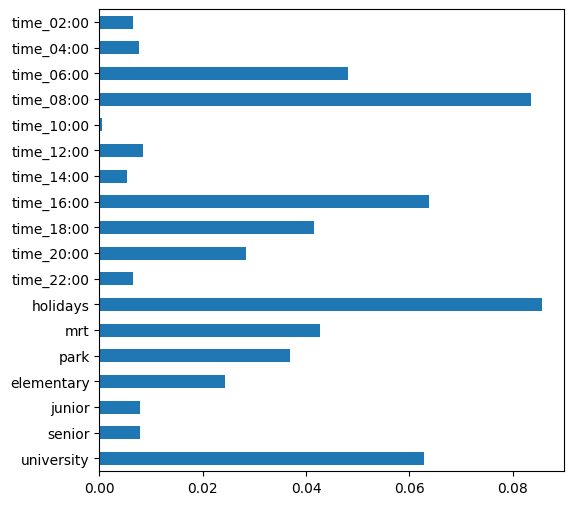

In [ ]:
from sklearn.inspection import permutation_importance
from sklearn.metrics import make_scorer

rf_pfi = permutation_importance( #得出類別重要性
    rf_estimator, 
    X_test, 
    y_test, 
    scoring = make_scorer(
    accuracy_score, 
    greater_is_better=True),
    n_repeats=100,
    random_state=48)

plt.figure(figsize = (6, 6))
_ = pd.Series(
    rf_pfi.importances_mean,
    index = transformed_feature_names).iloc[::-1].plot.barh()